In [1]:
import torch
import sys
sys.path.append('../')
import time, random
import numpy as np
from robust_tt import RTT 
from dyn_models.pushing_dyn_general_mm import pusher_slider_sys
torch.set_default_dtype(torch.float64)
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Note: Due to the randomness of TT-Cross approximation, 
# if the success rate is not 100% after training, please try different random seed.

# If you don't want to train by yourself, you can use the pre-trained model 
# in the folder "tt_models".

seed= 10
np.random.seed(seed)
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
p_target = torch.tensor([0., 0., 0.]).view(1,-1).to(device)
dt= 0.01
T=1000

dyn_system =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)

In [5]:
# dim=5
w = 0.5
state_max = torch.tensor([w,w,torch.pi, torch.pi, 0.05]).to(device) # (s_x, s_y, s_theta, psi, phi) 
state_min =  torch.tensor([-w,-w,-torch.pi, -torch.pi, 0]).to(device)


param_max = torch.tensor([0.20, 1.5, 0.8]).to(device) #(r, mass, u_gs, u_ps)
param_min = torch.tensor([0.06, 0.5, 0.2]).to(device) #(r, mass, u_gs, u_ps)

n_state = 50
n_param = 100
n_action = 50
n_action = [n_action]*4


v_max = 0.1
f_max = 3

u_ps = 1.0


action_max = torch.tensor([f_max, u_ps*f_max, torch.pi, 0.05]).to(device) # (fc_n, fc_t, psi_next, phi_next)
action_min = torch.tensor([0, -u_ps*f_max, -torch.pi, 0]).to(device) 

In [6]:
domain_state = [torch.linspace(state_min[i],state_max[i],n_state).to(device) for i in range(len(state_max))]
domain_param = [torch.linspace(param_min[i],param_max[i],n_param).to(device) for i in range(len(param_max))]
domain_action =[torch.linspace(action_min[i],action_max[i],n_action[i]).to(device) for i in range(len(action_max))]
domain_state_param = domain_state + domain_param

In [7]:
def forward_model(state_param,action):
    next_state = dyn_system.dynamics(state_param,action)
    return next_state


def reward(state_param,action):
    rewards = -1*dyn_system.cost_func(state_param,action,scale=w)
    return rewards

In [8]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.empty((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.25,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)


In [9]:
tol = torch.tensor([0.03, 0.03, 15/180*torch.pi]).to(device)[:3]

def callback(ttpi, state=state, file_name='fig',callback_count=0):
    print("Testing....")
    
    history = []

    param  = torch.tensor([0.20, 1.5, 0.8]).view(1,-1).expand(state.shape[0],-1).to(device)
    traj = state[:,:].clone()[:,None,:] #bsx(T+1)x6
    traj_actions = torch.empty(state.shape[0],T,4).to(device) #bsxTx3
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    dt_cum = 0
    for i in range(T):
        t0 = time.time()
        state_param = torch.cat((state,param),dim=-1)
        
        action = ttpi.policy(state_param)
        # print(action[0,0])
        t1=time.time()
        dt_cum+=(t1-t0)
        r = ttpi.reward_normalized(state_param,action)
        cum_reward+=r
        next_state_param = forward_model(state_param,action)
        state = next_state_param[:,:dim_state]
        traj = torch.concat((traj,state[:,None,:]),dim=1)
        traj_actions[:,i,:]=action
    print("time taken by policy: ", dt_cum/T)
    succ_rate = torch.sum(torch.all(torch.abs(state[:,:3])<=tol, dim=1))/n_test
    print(f"Success rate of {n_test} tests is {succ_rate*100}%")
    from plot_utils import plot_planarpush
    plot_num = 99 # number of plotted tasks
    plt=plot_planarpush(traj[-plot_num:].to('cpu').numpy(),
                        traj_actions[-plot_num:].to('cpu').numpy(), 
                        animation=False, step_skip=40, 
                        xmax=w,x_target=p_target[0].to('cpu').numpy(),figsize=5, 
                        save_as=None,
                        scale=10)
    plt.show()        
    return r.mean().to("cpu"), cum_reward.mean().to("cpu")
    

In [10]:
rtt = RTT(domain_state=domain_state+domain_param, domain_param=domain_param,
                domain_action=domain_action, 
                reward=reward, 
                normalize_reward=False,
                forward_model=forward_model, 
                gamma=0.99, dt=dt,
                rmax_v=100, rmax_a=100, 
                nswp_v=5, nswp_a=5, 
                kickrank_v=10, kickrank_a=20,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3,
                eps_cross_a=1e-3,
                eps_round_v=1e-4, 
                eps_round_a=1e-3, 
                n_samples=10, 
                verbose=True,
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

#############################################################################
Learning begins
#############################################################################
Computing reward function in TT format for normalization
cross device is cuda
Cross-approximation over a 12D domain containing 1.95312e+21 grid points:
iter: 0 | eps: 1.370e-01 | time:   1.0032 | largest rank:   1
iter: 1 | eps: 5.078e-06 | time:   1.1618 | largest rank:  21 <- converged: eps < 0.0001
Did 577900 function evaluations, which took 0.01636s (3.532e+07 evals/s)

Rank of reward:  tensor([1, 6, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1])
Initialize policy (q-fcn) by random initialization of value-function....
Testing....
time taken by policy:  0.003175053834915161
Success rate of 100 tests is 0.0%



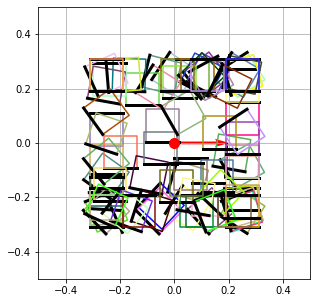

Memory:  0.000426496 0.7843348480000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 1/5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -1.42, v_mean: -0.74, v_max: -0.03
a_min: -143.38, a_mean: -74.48, a_max: -2.25
p_min: 142.13, p_mean: 211.02, p_max: 283.26
Rank of V-model:  tensor([1, 4, 2, 1, 1, 1, 1, 1, 1])
Rank of A-model:  tensor([1, 5, 4, 4, 3, 3, 3, 3, 3, 2, 1, 1, 1])
Rank of P-model:  tensor([1, 7, 6, 6, 5, 5, 5, 5, 5, 4, 3, 3, 1])
--------------------------------------------
Time taken:1.4080989360809326
--------------------------------------------
Memory:  0.000472064 0.008388608
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 2/5
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.........

.....................................................
Computing Advantage Fcn
.....................................................


v_min: -6.97, v_mean: -3.62, v_max: -0.10
a_min: -143.20, a_mean: -74.34, a_max: -2.31
p_min: 141.89, p_mean: 210.75, p_max: 282.78
Rank of V-model:  tensor([1, 5, 6, 5, 3, 2, 4, 6, 1])
Rank of A-model:  tensor([ 1,  8, 10, 10,  9, 11, 11, 18, 15, 13,  9,  2,  1])
Rank of P-model:  tensor([ 1, 10, 12, 12, 11, 13, 13, 20, 17, 15, 11,  4,  1])
--------------------------------------------
Time taken:15.138837814331055
--------------------------------------------
---------------Intermeditate Test-------------------------
Testing....
time taken by policy:  0.003181649446487427
Success rate of 100 tests is 100.0%



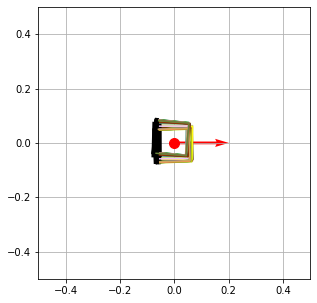

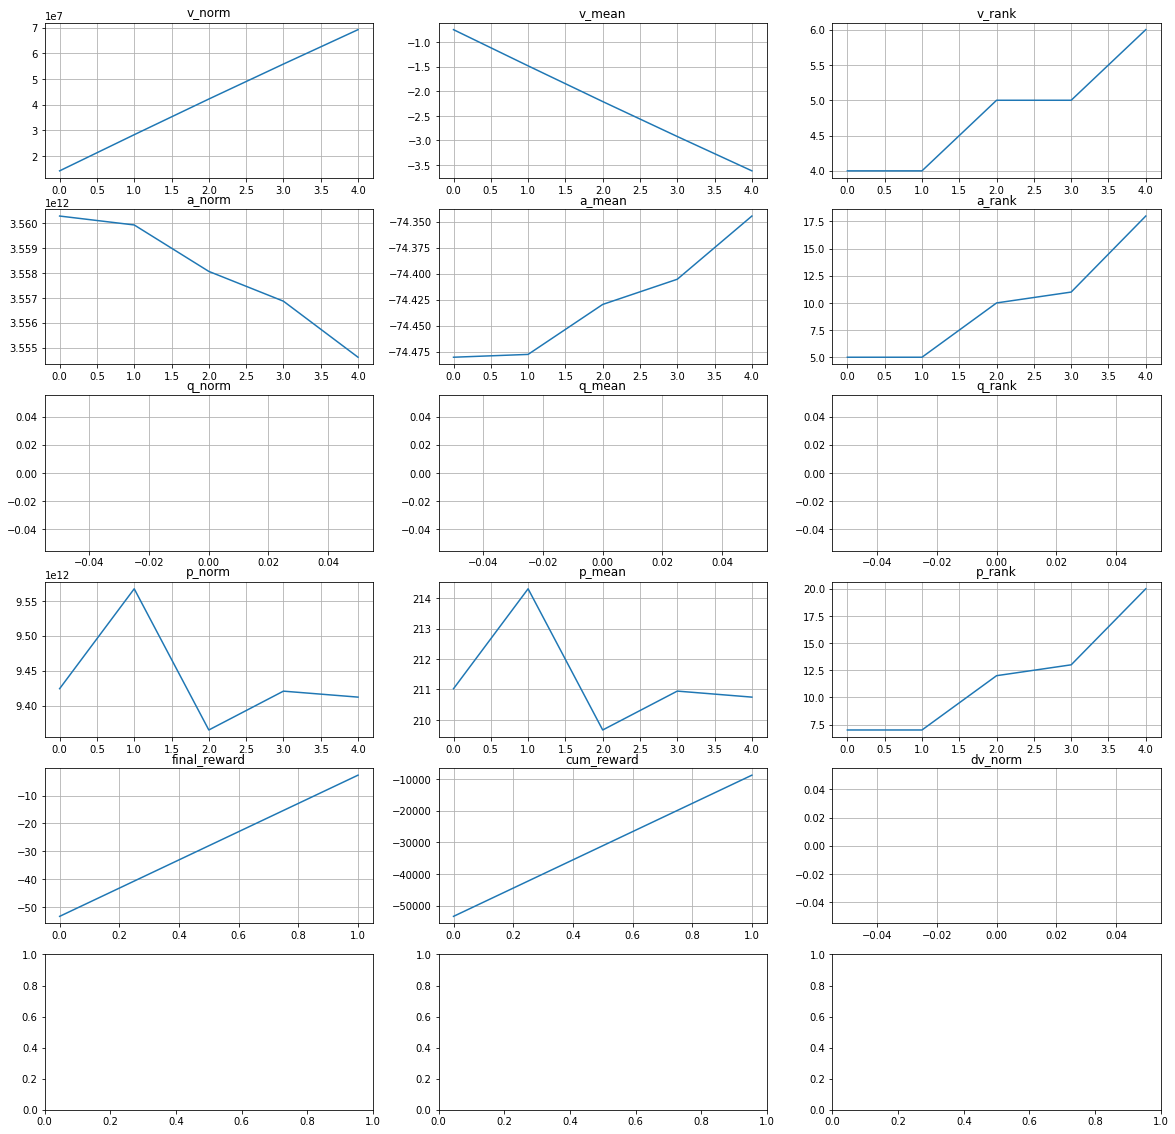

In [11]:
resume= False
rtt.train(n_iter_max=5,n_iter_v=1,
        callback=callback, callback_freq=5,
        verbose=False, file_name='pushing_test')
